## Reinforcement Learning (DDQN) Tutorial
Consulted sources relate to the following
 * https://medium.com/@leosimmons/double-dqn-implementation-to-solve-openai-gyms-cartpole-v-0-df554cd0614d
 * https://github.com/lsimmons2/double-dqn-cartpole-solution/blob/master/double_dqn.py
 * https://github.com/udacity/deep-reinforcement-learning/blob/master/dqn/exercise/dqn_agent.py

In [64]:
import gym
import math
import random
import numpy as np
np.random.seed(0)
import matplotlib
#import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import random
from matplotlib import pylab as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
#import torchvision.transforms as T
from collections import deque

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Define the model NN

In [65]:
HIDDEN_LAYER1 = 8  # NN hidden layer size
HIDDEN_LAYER2 = 16  # NN hidden layer size
HIDDEN_LAYER3 = 8  # NN hidden layer size
INPUT_SIZE = 4
OUTPUT_SIZE = 2

In [66]:
class DDQN(nn.Module):
    
    def __init__(self):
        nn.Module.__init__(self)
        self.l1 = INPUT_SIZE
        self.l2 = HIDDEN_LAYER1
        self.l3 = HIDDEN_LAYER2
        self.l4 = HIDDEN_LAYER3
        self.l5 = OUTPUT_SIZE
        
    def construct_model(self):
        model = nn.Sequential(nn.Linear(self.l1, self.l2),
                             nn.ReLU(),
                             nn.Linear(self.l2, self.l3),
                             nn.ReLU(),
                             nn.Linear(self.l3, self.l4),
                             nn.ReLU(),
                             nn.Linear(self.l4, self.l5))
        return model

Replay Memory
-------------

We'll be using experience replay memory for training our DQN. It stores
the transitions that the agent observes, allowing us to reuse this data
later. By sampling from it randomly, the transitions that build up a
batch are decorrelated. It has been shown that this greatly stabilizes
and improves the DQN training procedure.

For this, we're going to need two classses:

-  ``Transition`` - a named tuple representing a single transition in
   our environment. It essentially maps (state, action) pairs
   to their (next_state, reward) result, with the state being the
   screen difference image as described later on.
-  ``ReplayMemory`` - a cyclic buffer of bounded size that holds the
   transitions observed recently. It also implements a ``.sample()``
   method for selecting a random batch of transitions for training.




In [67]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'terminal'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        self.old_memory = []

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

The variable **transitions** looks as follows

[Transition(state=tensor([0.5854, 0.6407, 0.8513, 0.5702]), action=tensor([0.]), next_state=tensor([0.2927, 0.3844, 0.5959, 0.4562]), reward=tensor([1.]), terminal=tensor([0.])),
 Transition(state=tensor([0.9527, 0.5646, 0.6341, 0.0972]), action=tensor([1.]), next_state=tensor([0.4763, 0.3387, 0.4439, 0.0778]), reward=tensor([1.]), terminal=tensor([0.])),
 Transition(state=tensor([0.6957, 0.0152, 0.7158, 0.9815]), action=tensor([1.]), next_state=tensor([0.3478, 0.0091, 0.5011, 0.7852]), reward=tensor([1.]), terminal=tensor([1.]))]
 
 While the variable **minibatch** is a transition of batch arrays which looks as follows
 
Transition(state=(tensor([0.5854, 0.6407, 0.8513, 0.5702]), tensor([0.9527, 0.5646, 0.6341, 0.0972]), tensor([0.6957, 0.0152, 0.7158, 0.9815])), action=(tensor([0.]), tensor([1.]), tensor([1.])), next_state=(tensor([0.2927, 0.3844, 0.5959, 0.4562]), tensor([0.4763, 0.3387, 0.4439, 0.0778]), tensor([0.3478, 0.0091, 0.5011, 0.7852])), reward=(tensor([1.]), tensor([1.]), tensor([1.])), terminal=(tensor([0.]), tensor([0.]), tensor([1.])))

In [80]:
def optimize_model(): 
    """
    This function samples a certain batch and predicts the Q targets max(Q(S_t+1, a) + reward) and the Q current (Q(S_t, A_t)).
    The error between both is then used to optimize the predefined loss function (here MSE).
    """
    
    # Check the comment above to see how the following code works but we basically sample several samples (a batch)
    transitions = memory.sample(BATCH_SIZE)
    minibatch = Transition(*zip(*transitions))

    # Here we need to check whether or not we're in a terminal state. We first create a boolean tensor
    # Which indicates whether or not the next state is a final state and then gets all the next states
    # which are non final. This is needed later on for the computation because in a final state, the Q value = 0
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, minibatch.next_state)), dtype=torch.bool)

    # Concatenate the tensors of the next_states that are non final
    non_final_next_states = torch.stack([s for s in minibatch.next_state if s is not None])

    # Concatenate the tensors of the state, action and rewards
    state_batch = torch.stack(minibatch.state)
    action_batch = torch.cat(minibatch.action)
    reward_batch = torch.cat(minibatch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the columns of actions that were taken. 
    # These are the actions which would've been taken for each batch state according to online_net
    state_action_values = online_net(state_batch).gather(dim=1, index=action_batch.long().unsqueeze(dim=1)).squeeze()

    # Create a tensor with all zeros for the corresponding batch size
    next_state_values = torch.zeros(BATCH_SIZE)

    # Use the online network to SELECT the best action in each of the non final next states
    astar = torch.argmax(online_net(non_final_next_states), dim=1)
    
    # Use the target network to EVALUATE the actions chosen by the online net
    next_state_values[non_final_mask] = target_net(non_final_next_states).gather(dim=1, index = astar.unsqueeze(dim=1)).squeeze()

    # Compute the targets which correspond to the max of Q(S_t+1, a)*gamma + reward 
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    
    # We use Huber loss overhere but you can also use nn.MSELoss()
    #loss = F.smooth_l1_loss(state_action_values, expected_state_action_values)
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    batch_loss = loss.item()

    # clamp the parameters to be in the range of -1 and 1
    for param in online_net.parameters():
        param.grad.data.clamp_(-1, 1)
        
    optimizer.step()  
    my_lr_scheduler.step()
    
    return batch_loss

The following soft_update function performs the soft_update of the target parameters where 0 < TAU < 1. This idea comes from the following paper
* https://arxiv.org/pdf/1509.02971.pdf

In [81]:
def soft_update(online_net, target_net, tau):
    """Soft update model parameters.
    θ_target = τ*θ_online_net + (1 - τ)*θ_target_net
    Params
    ======
        online_net (PyTorch model): weights will be copied from
        target_net (PyTorch model): weights will be copied to
        tau (float): interpolation parameter 
    """
    for target_net_param, online_net_param in zip(target_net.parameters(), online_net.parameters()):
        target_net_param.data.copy_(tau*online_net_param.data + (1.0-tau)*target_net_param.data)
    
    return target_net

* model.eval() will notify all your layers that you are in eval mode, that way, batchnorm or dropout layers will work in eval mode instead of training mode.
* torch.no_grad() impacts the autograd engine and deactivate it. It will reduce memory usage and speed up computations but you won’t be able to backprop (which you don’t want in an eval script).


In [86]:
# Create the environment
env = gym.make('CartPole-v0').unwrapped

# Get number of actions from gym action space
n_actions = env.action_space.n

# Define the two DDQN networks
online_net = DDQN().to(device).construct_model()
target_net = DDQN().to(device).construct_model()
target_net.load_state_dict(online_net.state_dict())
target_net.eval()

#Remember that you must call model.eval() to set dropout and batch normalization layers 
#to evaluation mode before running inference. Failing to do this will yield inconsistent inference results.
loss_fn = nn.MSELoss()
LEARNING_RATE = 1e-3 # Learning rate for the neural network
#optimizer = optim.Adam(online_net.parameters(), LEARNING_RATE) # We will be learning the optimal parameters of the online net
optimizer = optim.Adam(online_net.parameters(), lr = LEARNING_RATE)

#decayRate = 0.9999 
#ExponentialLR Decays the learning rate of each parameter exponentially by every step taken
# (so in episode 1, LR = 0.001, in episode 2, LR = 0.001*decayRate etc)
# my_lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

#StepLR Decays learning rate every X steps with gamma so ex. episode 1-20, LR = 0.001, from episode 20-40, LR = 0.001*gamma
my_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5000, gamma=0.5)

EPSILON = 1 # Parameter for the epsilon greedy action choice
GAMMA = 0.90 # Discount factor
EPISODES = 500 # Number of episodes
MAX_MOVES = 200 # Max number of moves before the game is over
MEMORY_SIZE = 10000 # Total size of the experience replay memory
BATCH_SIZE = 256 # Sets the mini batch size
memory = ReplayMemory(MEMORY_SIZE) # Store samples in the replay memory
TAU = 0.5 # Target network soft update hyperparameter

In [87]:
avg_loss_per_episode = {}
total_returns_per_episode = {}

for episode in range(EPISODES):
    print("-"*30)
    print(f'Episode {episode}')
    episode_batch_loss = []
    episode_total_returns = []
    
    state_numpy = env.reset() # Get the beginning state as a numpy array
    state = torch.from_numpy(state_numpy).float() # Convert state to tensor
    
    episode_steps = 0
    terminal = False
    
    while terminal != True and episode_steps <= MAX_MOVES:
        qval = online_net(state) # Calculate the qvalue for the state
        qval_numpy = qval.data.numpy() # Convert the qvalues to a numpy array

        # Get the action to take (epsilon greedy)
        if (random.random() < EPSILON):
            action = np.random.randint(0,n_actions)
        else:
            action = np.argmax(qval_numpy)

        next_state_numpy, reward, terminal, _ = env.step(action) # Take the environment step and get the new_state
        
        # Append the reward to the total returns list
        episode_total_returns.append(reward)
        
        if terminal:
            next_state = None
        else:
            next_state = torch.from_numpy(next_state_numpy).float() # Convert new_state_numpy to tensor
        
        # Convert all the received variables into tensors and store them in the memory
        reward = torch.tensor([reward])
        action = torch.Tensor([action])
        terminal = torch.Tensor([terminal])
        memory.push(state, action, next_state, reward, terminal)
        
        # Run the gradient descent algorithm on the batches as soon as there are enough samples in the memory
        if len(memory) > BATCH_SIZE:
            batch_loss = optimize_model()
            episode_batch_loss.append(batch_loss)
            
            # Update the target network, one can just copy the online_net weights every X episodes to the target network.
            # However, one can also use a soft target network update which is used in this case. This incrementally updates
            # the target network weights to reflect the online network weights after every run of experience replay
            # target_weights = target_weights * (1-TAU) + q_weights * TAU
            # with 0 < TAU < 1
            soft_update(online_net, target_net, TAU)
        
        # Update the state to be the next_state
        state = next_state
        
        # Decay the epsilon parameter as long as it is above 0.05
        if EPSILON > 0.1:
            EPSILON -= (1/EPISODES)
        
        episode_steps += 1
        
    if len(episode_batch_loss) == 0:
        avg_loss_per_episode[episode] = 0
        total_returns_per_episode[episode] = sum(episode_total_returns)
    
    else:
        avg_loss_per_episode[episode] = sum(episode_batch_loss)/len(episode_batch_loss)
        total_returns_per_episode[episode] = sum(episode_total_returns)
        

------------------------------
Episode 0
------------------------------
Episode 1
------------------------------
Episode 2
------------------------------
Episode 3
------------------------------
Episode 4
------------------------------
Episode 5
------------------------------
Episode 6
------------------------------
Episode 7
------------------------------
Episode 8
------------------------------
Episode 9
------------------------------
Episode 10
------------------------------
Episode 11
------------------------------
Episode 12
------------------------------
Episode 13
------------------------------
Episode 14
------------------------------
Episode 15
------------------------------
Episode 16
------------------------------
Episode 17
------------------------------
Episode 18
------------------------------
Episode 19
------------------------------
Episode 20
------------------------------
Episode 21
------------------------------
Episode 22
------------------------------
Episode 23
--

------------------------------
Episode 194
------------------------------
Episode 195
------------------------------
Episode 196
------------------------------
Episode 197
------------------------------
Episode 198
------------------------------
Episode 199
------------------------------
Episode 200
------------------------------
Episode 201
------------------------------
Episode 202
------------------------------
Episode 203
------------------------------
Episode 204
------------------------------
Episode 205
------------------------------
Episode 206
------------------------------
Episode 207
------------------------------
Episode 208
------------------------------
Episode 209
------------------------------
Episode 210
------------------------------
Episode 211
------------------------------
Episode 212
------------------------------
Episode 213
------------------------------
Episode 214
------------------------------
Episode 215
------------------------------
Episode 216
-----------

------------------------------
Episode 385
------------------------------
Episode 386
------------------------------
Episode 387
------------------------------
Episode 388
------------------------------
Episode 389
------------------------------
Episode 390
------------------------------
Episode 391
------------------------------
Episode 392
------------------------------
Episode 393
------------------------------
Episode 394
------------------------------
Episode 395
------------------------------
Episode 396
------------------------------
Episode 397
------------------------------
Episode 398
------------------------------
Episode 399
------------------------------
Episode 400
------------------------------
Episode 401
------------------------------
Episode 402
------------------------------
Episode 403
------------------------------
Episode 404
------------------------------
Episode 405
------------------------------
Episode 406
------------------------------
Episode 407
-----------

Two main thoughts about what might cause an unstable policy

* A large learning rate means that the optimizer is forced to change policy weights, even when the policy is performing well.
* The exploration period being too short means that only late in life does the agent see certain parts of the state space, making the policy unstable in these regions of the state space

In [88]:
losses_per_episode = list(avg_loss_per_episode.values())
returns_per_episode = list(total_returns_per_episode.values())

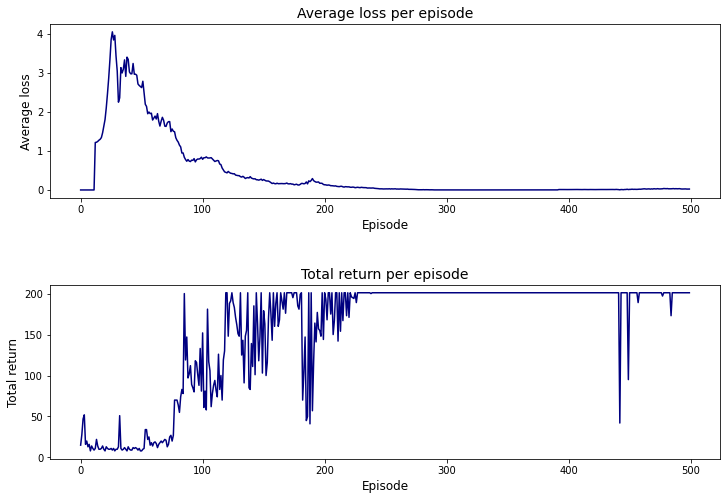

In [89]:
# Average loss per episode DDQN
fontsize_title = 14
fontsize_label = 12
plt.figure(figsize=(12, 8))
plt.subplot(211) #he subplot call specifies numrows, numcols, plot_number
plt.plot(losses_per_episode, color='navy');
plt.title("Average loss per episode", fontsize=fontsize_title)
plt.xlabel('Episode', fontsize=fontsize_label)
plt.ylabel('Average loss', fontsize=fontsize_label)

# Average return
plt.subplot(212)
plt.plot(returns_per_episode, color='navy');
plt.title("Total return per episode", fontsize=fontsize_title)
plt.xlabel('Episode', fontsize=fontsize_label)
plt.ylabel('Total return', fontsize=fontsize_label)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
plt.show()

## Save our model

In [90]:
# Specify a path to save the model
PATH = "saved_models/DDQN_CartPole_state_dict_model.pt"

# Save
torch.save(online_net.state_dict(), PATH)

## Load our model

In [91]:
PATH = "saved_models/DDQN_CartPole_state_dict_model.pt"
model = DDQN().construct_model();
model.load_state_dict(torch.load(PATH));
model.eval();

## Code to select the best possible action based on our predictions

In [92]:
def argmax(q_values):
    """
    Takes in a list of q_values and returns the index of the item 
    with the highest value. Breaks ties randomly.
    returns: int - the index of the highest value in q_values
    """
    top_value = float("-inf")
    ties = []
    
    top_value = max(q_values)
    
    for i in range(len(q_values)):
        # if a value in q_values is greater than the highest value update top and reset ties to zero
        # if a value is equal to top value add the index to ties
        # return a random selection from ties.
        if q_values[i] == top_value:
            ties.append(i)
    
    return np.random.choice(ties)

## Simulation

In [93]:
def random_simulation():
    env = gym.make('CartPole-v1')
    state = env.reset()
    for t in range(500):
        env.render()
        action = np.random.choice(env.action_space.n)
        state, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
    env.close()

In [95]:
random_simulation()

Episode finished after 14 timesteps


In [98]:
def watch_agent():
    env = gym.make('CartPole-v1')
    state = env.reset()
    for t in range(500):
        env.render()
        pred = model(torch.from_numpy(state).float()) # Predict what the action values are for a given input state
        action = argmax(pred.data.numpy()) # Convert the predictions (Tensor) to numpy array and get best possible action
        state, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
    env.close()

In [104]:
watch_agent()

Episode finished after 245 timesteps
